In [48]:
import os
import zipfile

try:
    from google.colab import drive
    RUNNING_IN_COLAB = True
    
except ImportError:
    drive = None
    RUNNING_IN_COLAB = False

if RUNNING_IN_COLAB:
    os.system('git clone https://github.com/vekshinnikita/face_recognition.git /content/face_recognition')
    os.chdir('/content/face_recognition') 
    
    drive.mount('/content/drive')
    
    zip_dataset_path = '/content/drive/MyDrive/recognition_dataset.zip'
    destination_dataset_path = '/content/face_recognition/'
    with zipfile.ZipFile(zip_dataset_path, 'r') as zip_ref:
      zip_ref.extractall(destination_dataset_path)

In [49]:
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from datetime import datetime

import torch
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import v2

from utils.display import show_image_with_bboxes
from dataset_classes.vgg_face2_classifier import VGGFace2ClassifierDataset, VGGFace2ClassifierArcDataset

from utils.system import get_available_device
from models.face_classifier_googlenet import FaceGoogLeNet, info_string as model_info_string
from loss.triplet_loss import TripletLoss
from loss.arcface_loss import ArcFaceLoss
from utils.classifier_model import aggregate_metrics, evaluate_recognition_batch, save_model


In [50]:
MODE = 'train' # 'train' | 'prod'
PATH_TO_SAVED_FILE = None # Путь к сохраненному файлу с параметрами

SAVE_BEST_DIR_PATH = './best_models/'
SAVE_BEST_FILE_NAME = 'googlenet_face_classifier_{start_datetime:%m-%d_%H:%M}_epoch_{epoch}.pt'

EPOCHS = 10
EMBEDDING_SIZE = 128

device = get_available_device()

GPU is not available, using CPU instead
Using device: cpu


In [51]:
SAVE_BEST_FILE_PATH = os.path.join(SAVE_BEST_DIR_PATH, SAVE_BEST_FILE_NAME)

def is_train():
    return MODE == 'train'

def is_load_from_saved():
    return PATH_TO_SAVED_FILE is not None

if is_load_from_saved():
    load_parameters = torch.load(PATH_TO_SAVED_FILE, weights_only=False, map_location=torch.device(device))

In [52]:
transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.uint8, scale=True),
    v2.Resize((224, 224)),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])

def reverse_transform(image: torch.Tensor):
    fn = v2.Compose([
        v2.Normalize(mean=(-0.5 / 0.5, -0.5 / 0.5, -0.5 / 0.5), std=(1 / 0.5, 1 / 0.5, 1 / 0.5)),
    ])
    
    return fn(image)

if is_train():
    dataset = VGGFace2ClassifierDataset(
        './recognition_dataset/images/test',
        './recognition_dataset/labels/test',
        transform,
        reverse_transform
    )

In [53]:
# from dataset_classes.balanced_batch_sample import BalancedBatchSampler


if is_train():
    train_set, val_set, test_set = random_split(dataset, [0.01, 0.01, 0.98])

    batch_size = 32
    
    # train_sample = BalancedBatchSampler(train_set, batch_size=batch_size, min_samples_per_class=3)
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [54]:
len(train_set.indices)

1694

In [55]:
model = FaceGoogLeNet(embedding_size=EMBEDDING_SIZE, pretrained=True).to(device)

if is_load_from_saved():
    model.load_state_dict(load_parameters['state_model'])

Anchor Embedding: tensor([ 3.0548e-01, -9.7628e-01, -5.3980e-01, -9.4196e-01, -1.8766e-02,
         5.5559e-01, -7.1841e-01,  7.9406e-01, -2.8788e-01,  1.8769e+00,
         1.2472e-01,  2.9569e-01,  5.5162e-01,  1.0838e+00, -1.6718e+00,
         3.7131e-01, -2.1599e+00, -7.8108e-01, -1.9378e+00,  4.2941e-01,
        -1.8843e-01,  1.9610e+00,  1.7864e+00, -9.6006e-01,  9.0211e-02,
         1.5952e+00, -2.0708e-02, -4.2212e-01, -1.7732e-01, -9.1719e-01,
         6.2802e-02,  1.2039e+00, -1.1785e+00,  6.5173e-01, -1.0905e+00,
         1.0005e+00, -2.2968e+00,  3.4953e-01, -5.9799e-01, -9.1335e-02,
        -5.5140e-01, -8.0126e-01, -1.4860e-01,  6.7042e-01, -1.2115e+00,
         1.3559e+00,  6.0366e-01, -1.1636e+00, -9.4888e-01,  1.5480e-01,
         1.1089e+00, -8.7886e-01, -5.1533e-01, -2.3127e-01, -3.4245e+00,
         6.7886e-01, -4.9138e-02,  1.0475e+00,  2.8162e-01,  1.3351e-01,
         1.3188e+00, -4.8728e-01,  4.2755e-01, -3.6350e-01, -4.6429e-01,
        -6.5293e-01, -5.6948e-01,

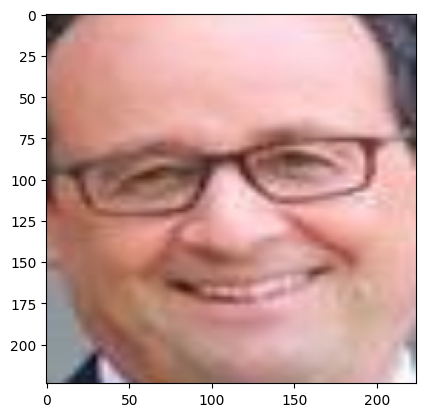

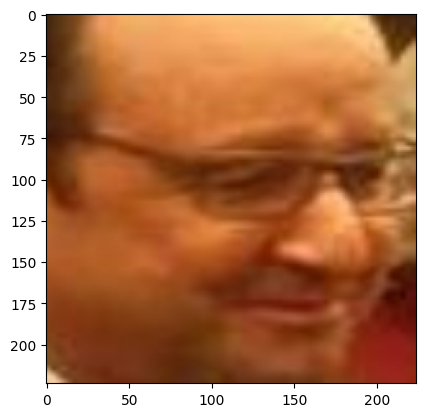

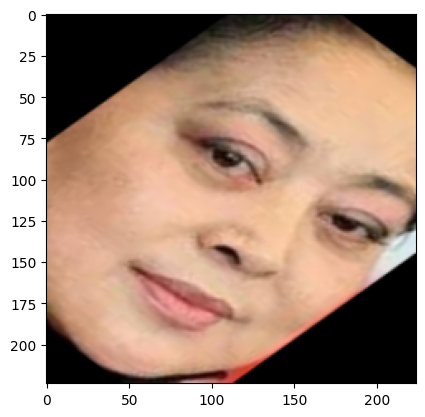

In [56]:
if is_train():
    model.eval()
    anchor, positive, negative = dataset[1100]
    
    anchor_data = anchor.unsqueeze(0).to(device)
    positive_data = positive.unsqueeze(0).to(device)
    negative_data = negative.unsqueeze(0).to(device)

    anchor_embedding = model.forward(anchor_data)[0]
    positive_embedding = model.forward(positive_data)[0]
    negative_embedding = model.forward(negative_data)[0]
    
    print(f'Anchor Embedding: {anchor_embedding}')
    print(f'Positive Embedding: {positive_embedding}')
    print(f'Negative Embedding: {negative_embedding}')

    show_image_with_bboxes(reverse_transform(anchor))
    show_image_with_bboxes(reverse_transform(positive))
    show_image_with_bboxes(reverse_transform(negative))


In [57]:
# Выбор функции потерь

if is_train():
    model_loss = TripletLoss()
    
    opt = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        opt, # оптимизатор.
        mode= 'min', # 'max' или 'min" - следим, чтобы отслеживаемый параметр увеличивался (*!
        factor=0.1, # коэффициент, на который будет умножен lr
        patience=10, # кол-во.эпох без улучшения отслеживаемого параметра.
    )
    
    if is_load_from_saved():
        opt.load_state_dict(load_parameters['state_opt'])
        lr_scheduler.load_state_dict(load_parameters['state_lr_scheduler'])

In [58]:
if is_train():
    start_from_epoch = 0
    
    train_loss = []
    train_accuracy = []
    train_frr = []
    train_far = []

    val_loss = []
    val_accuracy = []
    val_frr = []
    val_far = []

    lr_list = []
    best_loss = None
    
    if is_load_from_saved():
        # EPOCHS = load_parameters['epoch']['EPOCHS']
        start_from_epoch = load_parameters['epoch']['save_epoch']
        
        train_loss = load_parameters['loss']['train_loss']
        val_loss = load_parameters['loss']['val_loss']
        # best_loss = load_parameters['loss']['best_loss']
        
        train_accuracy = load_parameters['metric']['train_accuracy']
        train_frr = load_parameters['metric']['train_frr']
        train_far = load_parameters['metric']['train_far']
        val_accuracy = load_parameters['metric']['val_accuracy']
        val_frr = load_parameters['metric']['val_frr']
        val_far = load_parameters['metric']['val_far']
        
        lr_list = load_parameters['lr_list']
        

In [59]:
import torch.nn.functional as F

start_datetime = datetime.now()

if is_train():
    threshold = 0.1
    saved_epoch = None
    # Цикл обучения
    
    train_correct=0
    data_size=0
    
    for epoch in range(start_from_epoch, EPOCHS):
        
        # Тренировка модели
        train_loop = tqdm(train_loader, leave=False)
        running_train_loss = []
        
        batch_results = []
        
        model.train()
        for anchor, positive, negative in train_loop:

            anchor = anchor.to(device)
            positive = positive.to(device)
            negative = negative.to(device)
 
            # Прямой проход + расчет ошибки модели
            anchor_embeddings = model(anchor)
            positive_embeddings = model(positive)
            negative_embeddings = model(negative)
            
            loss = model_loss(anchor_embeddings, positive_embeddings, negative_embeddings)
            
            # Обратный проход
            opt.zero_grad()
            loss.backward()
            
            # Шаг оптимизации
            opt.step()
            
            running_train_loss.append(loss.item())
            mean_train_loss = sum(running_train_loss)/len(running_train_loss)

            batch_metrics = evaluate_recognition_batch(anchor_embeddings, positive_embeddings, negative_embeddings)
            batch_results.append(batch_metrics)
            
            train_loop.set_description(f"Epoch [{epoch+1}/{EPOCHS}], train_loss={mean_train_loss: .4f}")
            
            # Расчет значения метрики  
            # Сохранение значения функции потерь и метрики
    
        aggregated_metrics = aggregate_metrics(batch_results)
        
        train_loss.append(mean_train_loss)
        train_accuracy.append(aggregated_metrics['accuracy'])
        train_frr.append(aggregated_metrics['frr'])
        train_far.append(aggregated_metrics['far'])
        
        # Проверка модели (валидация)
        running_val_loss = []
        batch_results = []
        
        model.eval()
        with torch.no_grad():
            for anchor, positive, negative in val_loader:
                
                anchor = anchor.to(device)
                positive = positive.to(device)
                negative = negative.to(device)
    
                # Прямой проход + расчет ошибки модели
                anchor_embeddings = model(anchor)
                positive_embeddings = model(positive)
                negative_embeddings = model(negative)
                
                loss = model_loss(anchor_embeddings, positive_embeddings, negative_embeddings)
                
                running_val_loss.append(loss.item())
                mean_val_loss = sum(running_val_loss)/len(running_val_loss)
                
                batch_metrics = evaluate_recognition_batch(anchor_embeddings, positive_embeddings, negative_embeddings)
                batch_results.append(batch_metrics)
                    
            aggregated_metrics = aggregate_metrics(batch_results)
            
            val_loss.append(mean_val_loss)
            val_accuracy.append(aggregated_metrics['accuracy'])
            val_frr.append(aggregated_metrics['frr'])
            val_far.append(aggregated_metrics['far'])
                    
            # Расчет значения метрики
            # Сохранение значения функции потерь и метрики
        
        lr_scheduler.step(mean_val_loss)
        lr = lr_scheduler.get_last_lr()
        lr_list.append(lr)
        
        if best_loss is None:
            best_loss = mean_val_loss
        
        if mean_val_loss < best_loss - best_loss * threshold:
            best_loss = mean_val_loss
            
            # if saved_epoch is not None:
            #     prefix = SAVE_BEST_FILE_NAME.split('{start_datetime:%m-%d_%H:%M}')[0] + '{start_datetime:%m-%d_%H:%M}'
            #     delete_files_with_prefix(
            #         SAVE_BEST_DIR_PATH,
            #         prefix.format(start_datetime=start_datetime)
            #     )
            
            saved_epoch = epoch+1
            save_model(
                file_path=SAVE_BEST_FILE_PATH,
                str_info=model_info_string,
                model=model,
                start_datetime=start_datetime,
                opt=opt,
                lr_scheduler=lr_scheduler,
                train_loss=train_loss,
                val_loss=val_loss,
                best_loss=best_loss,
                train_accuracy=train_accuracy,
                train_frr=train_frr,
                train_far=train_far,
                val_accuracy=val_accuracy,
                val_frr=val_frr,
                val_far=val_far,
                lr_list=lr_list,
                EPOCHS=EPOCHS,
                epoch=epoch+1,
            )
            print(f'Ha эпoxe - {epoch+1}, сохранена модель со значением функции потерь на валидации - {mean_val_loss: 4f}', end='\n\n')
            
        mean_train_accuracy = sum(train_accuracy)/len(train_accuracy)
        mean_train_frr = sum(train_frr)/len(train_frr)
        mean_train_far = sum(train_far)/len(train_far)
        mean_val_accuracy = sum(val_accuracy)/len(val_accuracy)
        mean_val_frr = sum(val_frr)/len(val_frr)
        mean_val_far = sum(val_far)/len(val_far)

        print(f"Epoch [{epoch+1}/{EPOCHS}], train_loss={mean_train_loss: .4f}, train_accuracy={mean_train_accuracy: .4f}, train_frr={mean_train_frr: .4f}, train_far={mean_train_far: .4f}, val_loss={mean_val_loss: .4f}, val_accuracy={mean_val_accuracy: .4f}, val_frr={mean_val_frr: .4f}, val_far={mean_val_far: .4f}, lr={lr}")

  0%|          | 0/53 [00:00<?, ?it/s]

Epoch [1/10], train_loss= 0.8102, train_accuracy= 0.5000, train_frr= 1.0000, train_far= 0.0000, val_loss= 0.7495, val_accuracy= 0.5000, val_frr= 1.0000, val_far= 0.0000, lr=[0.001]


Epoch [2/10], train_loss= 0.6461, train_accuracy= 0.5000, train_frr= 1.0000, train_far= 0.0000, val_loss= 0.7013, val_accuracy= 0.5006, val_frr= 0.9988, val_far= 0.0000, lr=[0.001]


Директория уже существует: ./best_models
Ha эпoxe - 3, сохранена модель со значением функции потерь на валидации -  0.579391

Epoch [3/10], train_loss= 0.5904, train_accuracy= 0.5000, train_frr= 1.0000, train_far= 0.0000, val_loss= 0.5794, val_accuracy= 0.5015, val_frr= 0.9970, val_far= 0.0000, lr=[0.001]


KeyboardInterrupt: 

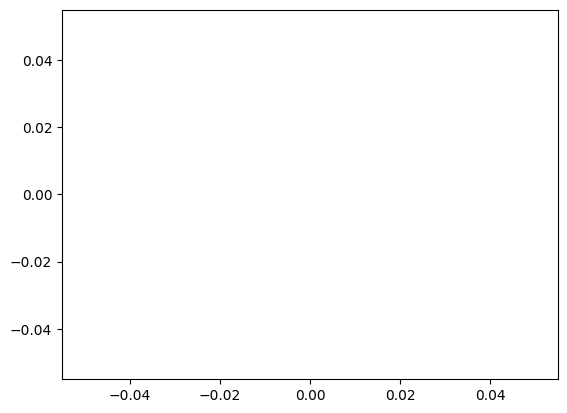

In [ ]:
if is_train():
    plt.plot(lr_list)
    plt.show()

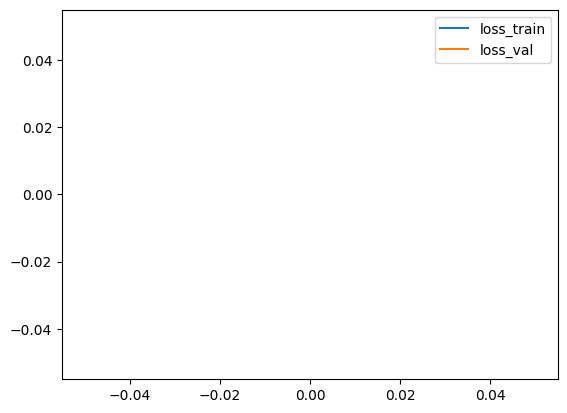

In [ ]:
if is_train():
    plt.plot(train_loss)
    plt.plot(val_loss)
    plt.legend(['loss_train', 'loss_val'])
    plt.show()

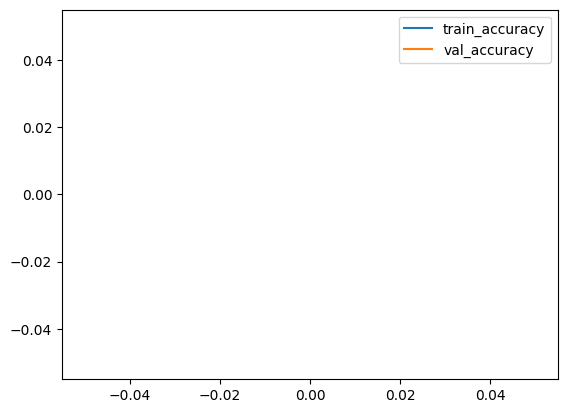

In [ ]:
if is_train():
    plt.plot(train_accuracy)
    plt.plot(val_accuracy)
    plt.legend(['train_accuracy', 'val_accuracy'])
    plt.show()

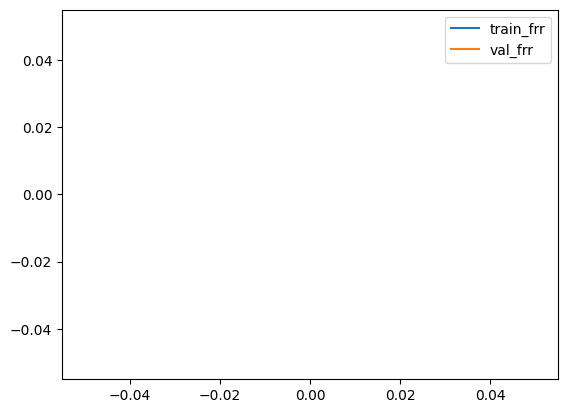

In [ ]:
if is_train():
    plt.plot(train_frr)
    plt.plot(val_frr)
    plt.legend(['train_frr', 'val_frr'])
    plt.show()

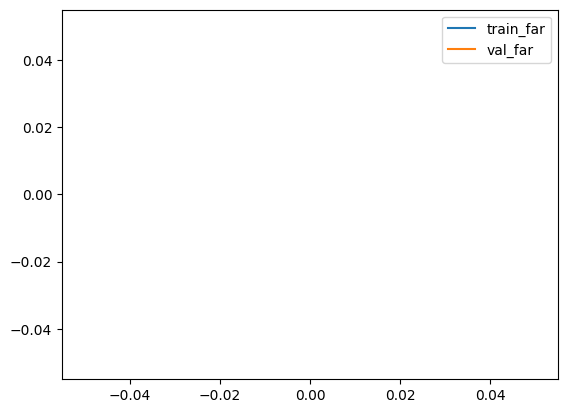

In [ ]:
if is_train():
    plt.plot(train_far)
    plt.plot(val_far)
    plt.legend(['train_far', 'val_far'])
    plt.show()